In [69]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge/')

#outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
outdir = 'results/main/coloc/summary/'
os.makedirs(outdir, exist_ok=True)

In [70]:
import pycircos
import collections
import matplotlib.pyplot as plt
import wget

In [71]:
# load gwas meta-data
gwas_samplesheet = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')
gwas_samplesheet.set_index('gwas_id', inplace=True)
gwas_samplesheet.index = gwas_samplesheet.index.str.replace('#', '')

## Loading the GENCODE Reference

In [72]:
# gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
# gencode = gencode.iloc[:, [5,6]]
# gencode.set_index(6, inplace=True)
# gencode = gencode.squeeze()
# gencode = gencode.to_dict()

# Load the gene data
gene_ref = 'results/refs/gencode/v30/gencode.v30.annotation.grch37.bed'
cols = ['chrom', 'start', 'end', 'strand', 'type', 'geneid', 'genename', 'detailed-type']
gencode = pd.read_table(gene_ref, header=None, names=cols)

# extract just the genes
genes_df = gencode.copy() #loc[gencode.type.isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='geneid'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df.set_index('geneid', inplace=True)

rev_gencode = {idx:sr.genename for idx, sr in genes_df.iterrows()}

## Loading and Processing the Colocalization Data 

In [73]:
major_cells = ['B-cell_naive', 'CD4_T-cell_naive',
               'CD8_T-cell_naive', 'NK-cell_naive','monocyte_naive']
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton'] #, 'T1D_25751624']

In [74]:
data = []
eqtl_cat_glob = 'results/main/coloc/Results/eQTL_Catalogue/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
eqtl_cat_glob = glob.glob(eqtl_cat_glob)
immunexut_glob = 'results/main/coloc/Results/ImmuNexUT/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
immunexut_glob = glob.glob(immunexut_glob)
coloc_fns = sorted(eqtl_cat_glob + immunexut_glob) 
coloc_fns = [x for x in coloc_fns if 'test' not in x]
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 170.


In [6]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    if gwas not in major_gwas:
        print('skipped gwas: {}'.format(gwas))
        continue 
        
    #     if ge not in major_cells:
    #         print('skipped ge:', ge)
    #         continue 

    #print('Processing: {}'.format(fn))
        
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

In [9]:
# add the gene name
t1d_data.geneName = t1d_data.geneName.str.replace('\.[0-9]*$', '', )
t1d_data['genename'] = t1d_data.geneName.replace(rev_gencode)

/tmp/ipykernel_106662/2572423673.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  t1d_data.geneName = t1d_data.geneName.str.replace('\.[0-9]*$', '', )


In [10]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [11]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'genename',
              'pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR',
              'slope_snp', 'slope_se_snp', 'slope_gwas', 'slope_se_gwas',
              'pval_nominal', 'gwas', 'eqtl', 'ge', 'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'genename': 'genename', 
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

In [12]:
# add gene metedata including coordinates
t1d_data = t1d_data.merge(genes_df.drop('genename', axis=1),
                           left_on='gene_id', right_on='geneid',
                           how='left', indicator=True)

In [13]:
t1d_data

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
0,chr6,90281412,rs639575,6:90281412:A:T,AL132996.1,0.818894,39031,2.984650e-04,2.285312e-02,-0.303919,0.011622,-0.129995,0.018999,7.803700e-12,T1D_25751624,BLUEPRINT,T-cell,ENSG00000260271,chr6,91030162.0,91072351.0,+,gene,lincRNA,both
1,chr10,88291278,rs7068821,10:88291278:G:T,ACTA2,0.784774,700061,7.952610e-02,6.179104e-01,-0.222309,0.030087,-0.171975,0.021997,5.359175e-15,T1D_25751624,BLUEPRINT,monocyte,ENSG00000107796,chr10,90694831.0,90751096.0,-,gene,protein_coding,both
2,chr16,75218429,rs8056814,16:75218429:G:A,NPIPB15,0.875031,840551,1.371830e-01,7.143720e-01,0.409247,0.012900,0.278010,0.031001,3.026552e-19,T1D_25751624,BLUEPRINT,neutrophil,ENSG00000196436,chr16,74411776.0,74425978.0,+,gene,protein_coding,both
3,chr21,42416077,rs11203203,21:42416077:G:A,CBS,0.803416,660866,3.976360e-02,6.782698e-01,-0.254951,0.029855,0.149971,0.018996,2.909284e-15,T1D_25751624,GENCORD,LCL,ENSG00000160200,chr21,44473301.0,44497053.0,-,gene,protein_coding,both
4,chr18,69876452,rs1788097,18:69876452:C:T,DOK6,0.818762,475564,2.058970e-07,1.051128e-04,0.446946,0.003681,0.117961,0.017994,5.543510e-11,T1D_25751624,GENCORD,LCL,ENSG00000206052,chr18,67068124.0,67516323.0,+,gene,protein_coding,both
5,chr18,69876452,rs1788097,18:69876452:C:T,DOK6,0.777308,475564,1.300000e-14,3.065720e-11,0.613805,0.001762,0.117961,0.017994,5.543510e-11,T1D_25751624,GENCORD,T-cell,ENSG00000206052,chr18,67068124.0,67516323.0,+,gene,protein_coding,both
6,chr21,42405613,rs9981624,21:42405613:G:C,TMPRSS3,0.812207,8767,5.466630e-15,1.352430e-11,0.601221,0.003727,0.152034,0.019004,1.244192e-15,T1D_25751624,GENCORD,T-cell,ENSG00000160183,chr21,43791946.0,43816955.0,-,gene,protein_coding,both
7,chr18,69866164,rs1790932,18:69866164:C:T,DOK6,0.849128,465276,2.684030e-06,1.775430e-03,-0.514310,0.002621,0.117961,0.017994,5.543510e-11,T1D_25751624,GTEx,LCL,ENSG00000206052,chr18,67068124.0,67516323.0,+,gene,protein_coding,both
8,chr2,162254026,rs2111485,2:162254026:A:G,DPP4,0.876449,179811,5.680480e-02,7.983550e-01,0.316478,0.009474,-0.164993,0.018999,3.813819e-18,T1D_25751624,GTEx,LCL,ENSG00000197635,chr2,162848755.0,162930725.0,-,gene,protein_coding,both
9,chr11,2160994,rs689,11:2160994:A:T,C11orf21,0.970779,142055,2.471160e-02,6.837600e-01,-0.794250,0.001089,-0.869884,0.026651,1.110000e-233,T1D_25751624,GTEx,LCL,ENSG00000110665,chr11,2316875.0,2324279.0,-,gene,protein_coding,both


### Save a unique list of SNPs within an SGL

In [67]:
gwas_grps = t1d_data.groupby('gwas_source')
for gwas_source, gwas_df in gwas_grps:
    
    print(gwas_source)
    
    gwas_df['sid'] = gwas_df['chr'] + '-' + gwas_df['pos'].astype(str)   
    uniq_sids = gwas_df['sid'].drop_duplicates().sort_values()
    uniq_sids = uniq_sids.str.replace(':', '-')
    
    fn = os.path.join(outdir, 'coloc_sgls.{}.tsv'.format(gwas_source))
    uniq_sids.to_csv(fn, header=False, index=False)

T1D_25751624
T1D_32005708
T1D_34012112_Gaulton
T1D_34594039_GCST90018925


### Checking Colocalized SNPs with Significant eQTLs (FDR<0.05)

In [14]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['gwas_source', 'eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['gwas_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [16]:
sig_eqtls.head()

chr       pos            varid  \
gwas_source  ge_source rsid                                          
T1D_25751624 T-cell    rs639575    chr6  90281412   6:90281412:A:T   
             LCL       rs1788097  chr18  69876452  18:69876452:C:T   
             T-cell    rs1788097  chr18  69876452  18:69876452:C:T   
                       rs9981624  chr21  42405613  21:42405613:G:C   
             LCL       rs1790932  chr18  69866164  18:69866164:C:T   

                                    genename      ppH4  sg_dist     eqtl_pval  \
gwas_source  ge_source rsid                                                     
T1D_25751624 T-cell    rs639575   AL132996.1  0.818894    39031  2.984650e-04   
             LCL       rs1788097        DOK6  0.818762   475564  2.058970e-07   
             T-cell    rs1788097        DOK6  0.777308   475564  1.300000e-14   
                       rs9981624     TMPRSS3  0.812207     8767  5.466630e-15   
             LCL       rs1790932        DOK6  0.849128   465276  2.684030e-06   

                                      eqtl_fdr  eqtl_slope  eqtl_slope_se  \
gwas_source  ge_source rsid                                                 
T1D_25751624 T-cell    rs639575   2.285312e-02   -0.303919       0.011622   
             LCL       rs1788097  1.051128e-04    0.446946       0.003681   
             T-cell    rs1788097  3.065720e-11    0.613805       0.001762   
                       rs9981624  1.352430e-11    0.601221       0.003727   
             LCL       rs1790932  1.775430e-03   -0.514310       0.002621   

                                  gwas_slope  gwas_slope_se     gwas_pval  \
gwas_source  ge_source rsid                                                 
T1D_25751624 T-cell    rs639575    -0.129995       0.018999  7.803700e-12   
             LCL       rs1788097    0.117961       0.017994  5.543510e-11   
             T-cell    rs1788097    0.117961       0.017994  5.543510e-11   
                       rs9981624    0.152034       0.019004  1.244192e-15   
             LCL       rs1790932    0.117961       0.017994  5.543510e-11   

                                 eqtl_source          gene_id  
gwas_source  ge_source rsid                                    
T1D_25751624 T-cell    rs639575    BLUEPRINT  ENSG00000260271  
             LCL       rs1788097     GENCORD  ENSG00000206052  
             T-cell    rs1788097     GENCORD  ENSG00000206052  
                       rs9981624     GENCORD  ENSG00000160183  
             LCL       rs1790932        GTEx  ENSG00000206052

## Checking the Sources of Colocalized Datasets

In [17]:
check_sources = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source'])
check_sources = check_sources[['gwas_source', 'eqtl_source', 'ge_source']]

In [18]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index(['gwas_source', 'eqtl_source']))
pd.set_option('display.max_rows', 20) 

ge_source
gwas_source               eqtl_source                        
T1D_25751624              BLUEPRINT                    T-cell
                          BLUEPRINT                  monocyte
                          BLUEPRINT                neutrophil
                          GENCORD                         LCL
                          GENCORD                      T-cell
...                                                       ...
T1D_34594039_GCST90018925 Schmiedel_2018           Tfh_memory
                          Schmiedel_2018          Th17_memory
                          Schmiedel_2018           Th1_memory
                          Schmiedel_2018           Th2_memory
                          Schmiedel_2018  monocyte_CD16_naive

[170 rows x 1 columns]

## Plotting the Number of SNP-Gene Pairs per Colocalization Analysis

In [19]:
study_summary = t1d_data.\
            value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index().\
            sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
study_summary.rename(columns={0:'count'}, inplace=True)

In [20]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 2.0.


In [21]:
study_summary.sort_values('count', ascending=False)

,gwas_source,eqtl_source,ge_source,count
0,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,7
1,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,7
2,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,5
3,T1D_34012112_Gaulton,Schmiedel_2018,Th2_memory,4
4,T1D_34012112_Gaulton,ImmuNexUT,CM_CD8,4
...,...,...,...,...
165,T1D_32005708,GTEx,blood,1
166,T1D_32005708,GTEx,LCL,1
167,T1D_32005708,BLUEPRINT,neutrophil,1
168,T1D_32005708,BLUEPRINT,monocyte,1


In [22]:
eqtl_colors = study_summary.eqtl_source.unique()
eqtl_colors = {k:v for k,v in zip(eqtl_colors, sns.color_palette(n_colors=len(eqtl_colors)))}

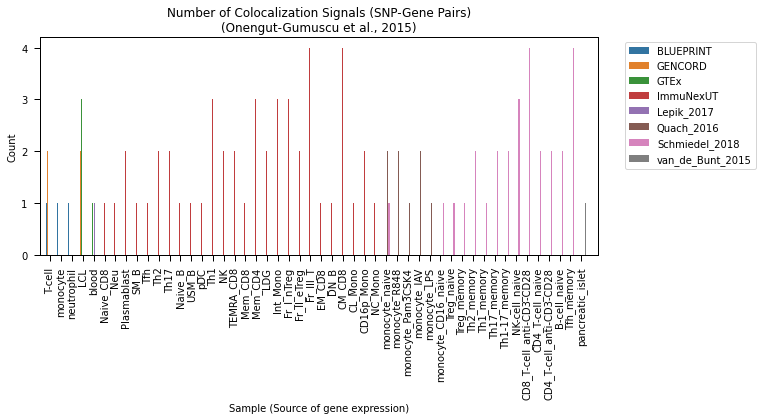

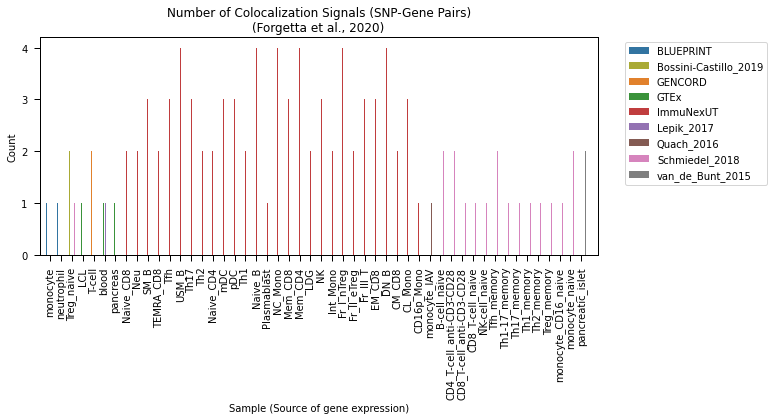

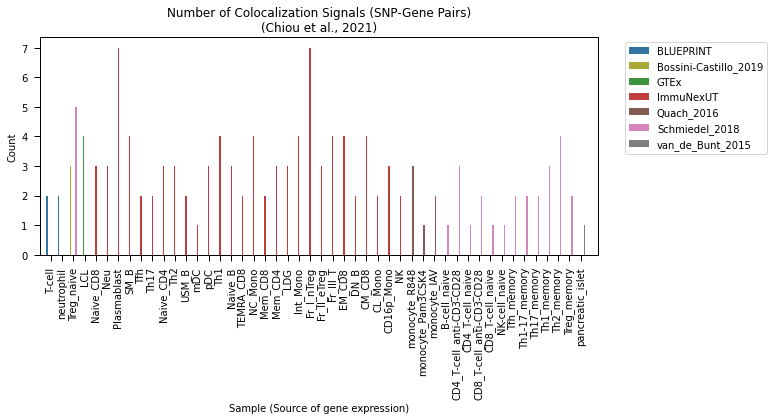

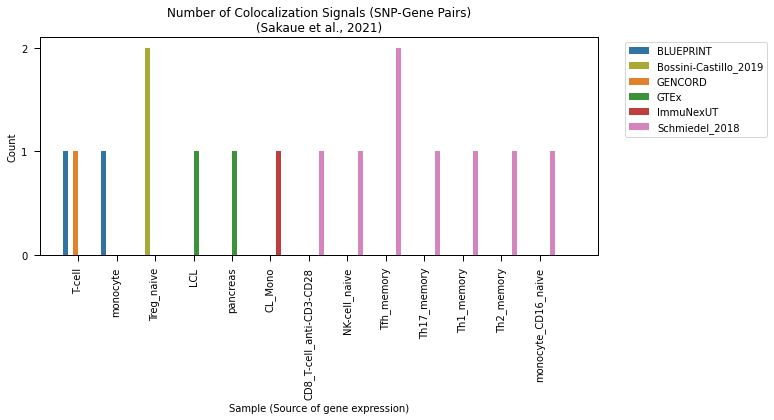

In [23]:
for gwas_source, gwas_summary in study_summary.groupby('gwas_source'):
        
    #sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="count",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # rotate the tick marks
    for x in g.get_xticklabels():
        x.set_rotation(90)
        

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']
    g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')
    g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))
    
    # expand the x limits
    ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)


#### Plotting all together

(-1.0, 13.5)

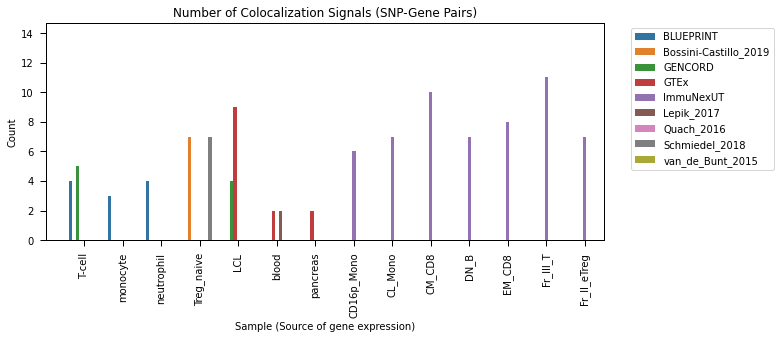

In [24]:
all_together = study_summary.groupby(['eqtl_source', 'ge_source'])['count'].sum().to_frame().reset_index()
#all_together.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,4))

# Draw a nested barplot by species and sex
g = sns.barplot(data=all_together,
            x="ge_source", y="count", hue='eqtl_source', palette=sns.color_palette(n_colors=len(all_together)), ax=ax)

# move the legend
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# rotate the tick marks
for x in g.get_xticklabels():
    x.set_rotation(90)

g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)')
g.set_xlabel('Sample (Source of gene expression)')
g.set_ylabel('Count')
#g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))

# expand the x limits
ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)

In [25]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [26]:
uniq_genes_per_sample = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

In [27]:
uniq_genes_per_sample

,gwas_source,eqtl_source,ge_source,genename
0,T1D_25751624,BLUEPRINT,T-cell,1
1,T1D_25751624,BLUEPRINT,monocyte,1
2,T1D_25751624,BLUEPRINT,neutrophil,1
3,T1D_25751624,GENCORD,LCL,2
4,T1D_25751624,GENCORD,T-cell,2
...,...,...,...,...
165,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2
166,T1D_34594039_GCST90018925,Schmiedel_2018,Th17_memory,1
167,T1D_34594039_GCST90018925,Schmiedel_2018,Th1_memory,1
168,T1D_34594039_GCST90018925,Schmiedel_2018,Th2_memory,1


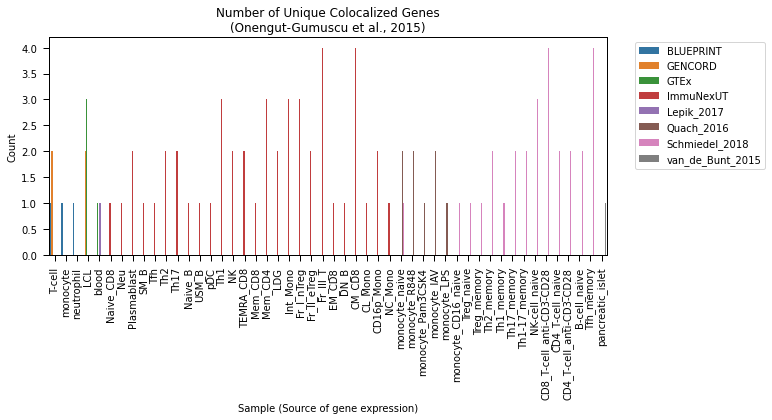

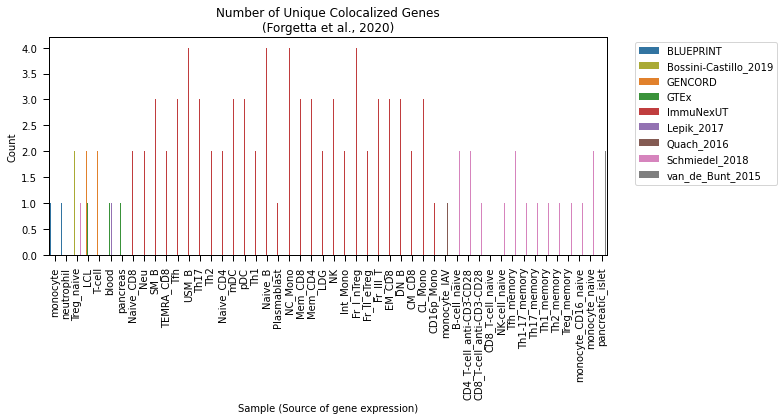

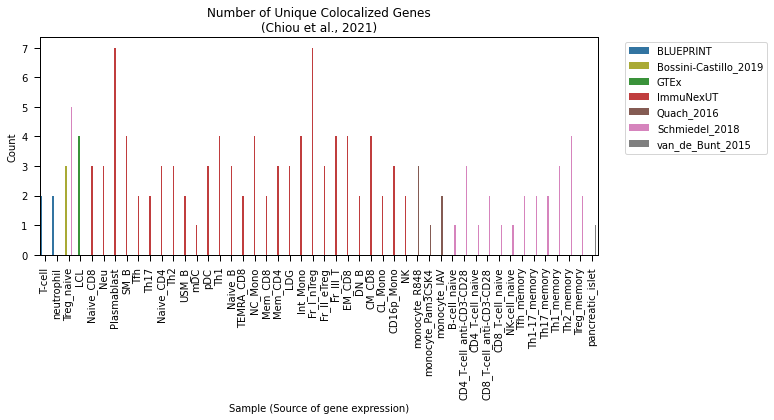

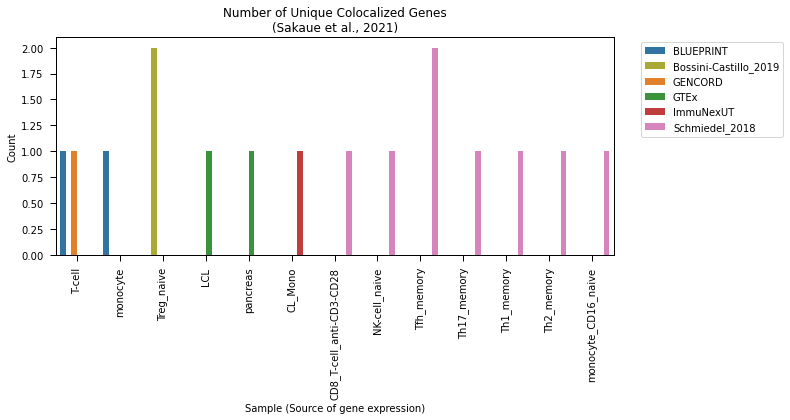

In [28]:
for gwas_source, gwas_summary in uniq_genes_per_sample.groupby('gwas_source'):
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="genename",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    

    for x in g.get_xticklabels():
        x.set_rotation(90)

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']    
    g.set_title('Number of Unique Colocalized Genes\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')

In [29]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).rsid.nunique().reset_index()

### Table for the number of unique genes and snps per colocalization analyses

In [30]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['gwas', 'eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

In [31]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values(['gwas', 'Unique # SNPs'], ascending=False))
pd.set_option('display.max_rows', 20) 

,gwas,eqtl,ge,Unique # Genes,Unique # SNPs
158,T1D_34594039_GCST90018925,Bossini-Castillo_2019,Treg_naive,2,2
165,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2,2
156,T1D_34594039_GCST90018925,BLUEPRINT,T-cell,1,1
157,T1D_34594039_GCST90018925,BLUEPRINT,monocyte,1,1
159,T1D_34594039_GCST90018925,GENCORD,T-cell,1,1
...,...,...,...,...,...
49,T1D_25751624,Schmiedel_2018,Treg_memory,1,1
50,T1D_25751624,Schmiedel_2018,Treg_naive,1,1
51,T1D_25751624,Schmiedel_2018,monocyte_CD16_naive,1,1
52,T1D_25751624,Schmiedel_2018,monocyte_naive,1,1


### Table for the number snps per gene

In [32]:
# find the uniq snps
uniq_snps_per_genes = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source', 'gene_id'])

In [33]:
uniq_snps_per_genes = uniq_snps_per_genes.rsid.nunique().reset_index()

In [34]:
uniq_snps_per_genes.sort_values('rsid', ascending=False)

,gwas_source,eqtl_source,ge_source,gene_id,rsid
134,T1D_32005708,ImmuNexUT,Mem_CD4,ENSG00000198270,2
114,T1D_32005708,ImmuNexUT,DN_B,ENSG00000111300,2
0,T1D_25751624,BLUEPRINT,T-cell,ENSG00000260271,1
242,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000235945,1
241,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000206052,1
...,...,...,...,...,...
117,T1D_32005708,ImmuNexUT,EM_CD8,ENSG00000197728,1
116,T1D_32005708,ImmuNexUT,DN_B,ENSG00000197728,1
115,T1D_32005708,ImmuNexUT,DN_B,ENSG00000134460,1
113,T1D_32005708,ImmuNexUT,CM_CD8,ENSG00000198270,1


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [35]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 145 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
DOK6,39
RPS26,37
TMPRSS3,19
TMEM116,13
AC068254.1,7
PUS10,6
IL2RA,6
AC016747.1,6
AC016747.2,4
GLIS3,4


In [36]:
msg = 'The number of genes across all colocalization analyses is: {}'.format(gene_uniq_summary.shape[0])
print(msg)

The number of genes across all colocalization analyses is: 145


In [37]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

ABCG1
AC002543.1
AC008063.1
AC008063.2
AC010733.1
AC016747.1
AC016747.2
AC016747.3
AC021205.3
AC027228.1
AC063965.1
AC068254.1
AC091196.1
AC091563.1
ACTA2
ADAM1B
AKR1C4
AL096678.1
AL121787.1
AL132996.1
AL133370.1
AL133445.2
AL137186.1
AL137779.2
AL137856.1
AL157394.1
AL157394.2
AL157395.1
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL355303.1
AL359317.1
AL513548.4
ALDH2
ANKRD22
ANKRD6
AP001610.1
AP001625.2
AP005131.7
AP005137.2
ARMH2
ASB13
BACH2
BBS12
BBS7
BCL11A
BEGAIN
BTN2A2
BTN3A1
BTN3A2
C11orf21
C1QTNF6
C2CD2
C2orf74
CACHD1
CBS
CD226
CENPW
CFL1P1
CTLA4
DEGS2
DOCK7
DOK6
DPP4
DSCC1
DUSP22
ENSG00000273802
ENSG00000278705
FGF2
FIGNL1
GABRR2
GLIS3
GMNN
GPLD1
GPN3
HIST1H1A
HIST1H1PS1
HIST1H2AE
HIST1H2BH
HIST1H3D
HIST1H4E
HUS1B
IL2RA
ITPR3
KCNQ1-AS1
LINC00863
LINC01031
LINC01550
LINC02285
LINC02320
LINC02356
LINC02561
LINC02648
LIPM
LSM8
MAGI3
MAP3K7
MAPKAPK5
MAPKAPK5-AS1
NAA25
NDUFV3
NONOP2
NPIPB15
NUDT6
PAPOLG
PAPSS2
PEX13
PGM1
PHETA1
PKNOX1
PM20D2
PRDM15
PRKCQ
PRKCQ-AS1
PTPN22
PUS10
RB

### Quick dive into COLOC for analyses

In [48]:
select_cells = ['Plasmablast', 'Fr_I_nTreg']
select_data = t1d_data.loc[(t1d_data.gwas_source == 'T1D_34012112_Gaulton') & 
             (t1d_data.eqtl_source == 'ImmuNexUT') &
             (t1d_data.ge_source.isin(select_cells))]

In [49]:
select_data.loc[select_data.ge_source == 'Fr_I_nTreg']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,...,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
234,chr9,4292083,rs10758593,9:4292083:G:A,SPATA6L,0.775475,374591,2.811760e-03,1.527113e-01,0.203818,...,ImmuNexUT,Fr_I_nTreg,ENSG00000106686,chr9,4553386.0,4666674.0,-,gene,protein_coding,both
235,chr2,60406328,rs13035645,2:60406328:T:A,AC016747.3,0.894993,793651,3.547170e-02,5.474464e-01,0.697347,...,ImmuNexUT,Fr_I_nTreg,ENSG00000273302,chr2,61427114.0,61427904.0,+,gene,sense_intronic,both
236,chr7,117462031,rs177069,7:117462031:A:G,AC002543.1,0.777563,585655,2.386220e-01,8.590260e-01,-0.435143,...,ImmuNexUT,Fr_I_nTreg,ENSG00000235945,chr7,116513508.0,116516430.0,-,gene,processed_pseudogene,both
237,chr18,69866164,rs1790932,18:69866164:C:T,DOK6,0.892936,465109,1.591880e-06,3.157811e-04,-0.268596,...,ImmuNexUT,Fr_I_nTreg,ENSG00000206052,chr18,67068124.0,67516323.0,+,gene,protein_coding,both
238,chr14,100841366,rs34337125,14:100841366:G:A,BEGAIN,0.848185,253953,1.486410e-02,3.879238e-01,-0.224439,...,ImmuNexUT,Fr_I_nTreg,ENSG00000183092,chr14,101003484.0,101053750.0,-,gene,protein_coding,both
239,chr1,113285485,rs773560,1:113285485:G:A,MAGI3,0.979196,105264,1.936030e-02,4.354628e-01,0.184124,...,ImmuNexUT,Fr_I_nTreg,ENSG00000081026,chr1,113933137.0,114228545.0,+,gene,protein_coding,both
240,chr21,42405613,rs9981624,21:42405613:G:C,TMPRSS3,0.908288,8767,9.030490e-11,4.013683e-08,0.710931,...,ImmuNexUT,Fr_I_nTreg,ENSG00000160183,chr21,43791946.0,43816955.0,-,gene,protein_coding,both


In [50]:
select_data.loc[select_data.ge_source == 'Plasmablast']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,...,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
271,chr1,63657608,rs11208260,1:63657608:G:A,PGM1,0.855703,64332,1.720090e-08,2.605504e-06,-0.308641,...,ImmuNexUT,Plasmablast,ENSG00000079739,chr1,64059082.0,64125916.0,+,gene,protein_coding,both
272,chr2,60406328,rs13035645,2:60406328:T:A,PAPOLG,0.911215,349902,5.009830e-02,5.144423e-01,0.281216,...,ImmuNexUT,Plasmablast,ENSG00000115421,chr2,60983388.0,61029221.0,+,gene,protein_coding,both
273,chr22,37185445,rs229527,22:37185445:C:A,C1QTNF6,0.795971,13940,6.898180e-23,4.903488e-20,-0.588069,...,ImmuNexUT,Plasmablast,ENSG00000133466,chr22,37576206.0,37595425.0,-,gene,protein_coding,both
274,chr9,4290823,rs6476839,9:4290823:A:T,RFX3,0.791872,764819,1.877290e-04,1.147042e-02,0.211862,...,ImmuNexUT,Plasmablast,ENSG00000080298,chr9,3218297.0,3526004.0,-,gene,protein_coding,both
275,chr12,112412095,rs7300285,12:112412095:G:A,TMEM116,0.973973,398910,8.866680e-04,4.142134e-02,0.356715,...,ImmuNexUT,Plasmablast,ENSG00000198270,chr12,112369086.0,112450989.0,-,gene,protein_coding,both
276,chr1,113285485,rs773560,1:113285485:G:A,SLC16A1-AS1,0.972030,329070,1.377070e-03,5.862208e-02,0.181735,...,ImmuNexUT,Plasmablast,ENSG00000226419,chr1,113499037.0,113589677.0,+,gene,antisense,both
277,chr21,42415901,rs80054410,21:42415901:T:C,UMODL1,0.881957,352942,1.406260e-01,7.162503e-01,0.245636,...,ImmuNexUT,Plasmablast,ENSG00000177398,chr21,43483068.0,43563563.0,+,gene,protein_coding,both


## Saving genes for excel analysis 

In [51]:
# find the unique SNPs
uniq_snps_by_cells = t1d_data.groupby('ge_source').varid.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

#find the unique genes 
uniq_genes_by_cells = t1d_data.groupby('ge_source').gene_id.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [52]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='colocalization')

In [53]:
excel_analysis

'results/notebooks/colocalization_with_eqtl_catalogue/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [54]:
gh_list = t1d_data.gene_id.unique()
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

#### Get the unique genes per cell type 

In [55]:
genes_by_cell = t1d_data[['ge_source', 'gene_id']].drop_duplicates()
genes_by_cell.sort_values(['ge_source', 'gene_id'], inplace=True)
genes_by_cell['source'] = 'colocalization'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

In [56]:
genes_by_cell

,cline,geneid,source
68,B-cell_naive,ENSG00000138685,colocalization
69,B-cell_naive,ENSG00000170677,colocalization
184,B-cell_naive,ENSG00000197728,colocalization
185,B-cell_naive,ENSG00000237943,colocalization
307,B-cell_naive,ENSG00000258837,colocalization
...,...,...,...
341,pancreas,ENSG00000285571,colocalization
96,pancreatic_islet,ENSG00000160181,colocalization
202,pancreatic_islet,ENSG00000197728,colocalization
203,pancreatic_islet,ENSG00000198610,colocalization


## Drawing Density of Distances between SNP and Genes Pairs 

In [42]:
t = t1d_data.loc[t1d_data['eqtl_source'] == 'Schmiedel_2018']

<AxesSubplot:xlabel='sg_dist', ylabel='Probability'>

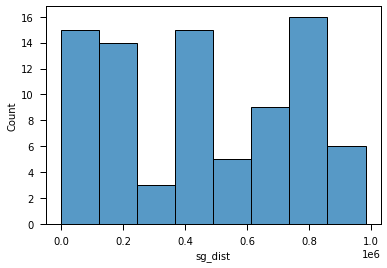

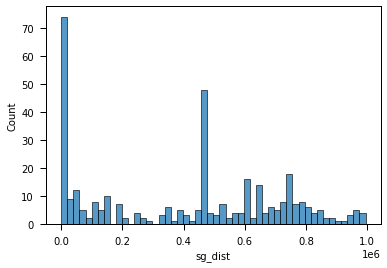

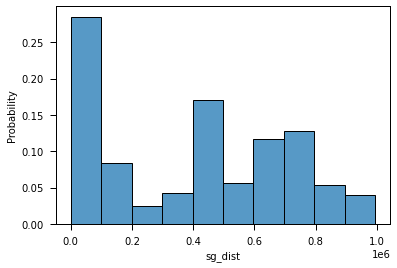

In [44]:
fig, ax = plt.subplots()
sns.histplot(t['sg_dist'], stat='count')

fig, ax = plt.subplots()
sns.histplot(t1d_data['sg_dist'], bins=50, stat='count')

fig, ax = plt.subplots()
sns.histplot(t1d_data['sg_dist'], stat='probability')

In [45]:
t1d_data['sg_dist'].describe()

count       358.00000
mean     400467.24581
std      308229.19086
min         292.00000
25%       44965.00000
50%      463705.00000
75%      650731.00000
max      994395.00000
Name: sg_dist, dtype: float64

This is very important to note, about 60% of SNP-Gene Pairs are 400kb apart. This will severly limit the amount of overlapping loops.

## Drawing CorrPlots between GWAS p-values, eQTL p-values and Coloc PP4

In [46]:
corr_data = t1d_data[['gwas_pval', 'eqtl_pval', 'eqtl_fdr', 'ppH4', 'sg_dist']]
corr_data.columns = ['GWAS P-value', 'eQTL P-value', 'eQTL FDR', 'COLOC PP4', 'SNP-Gene Distance']

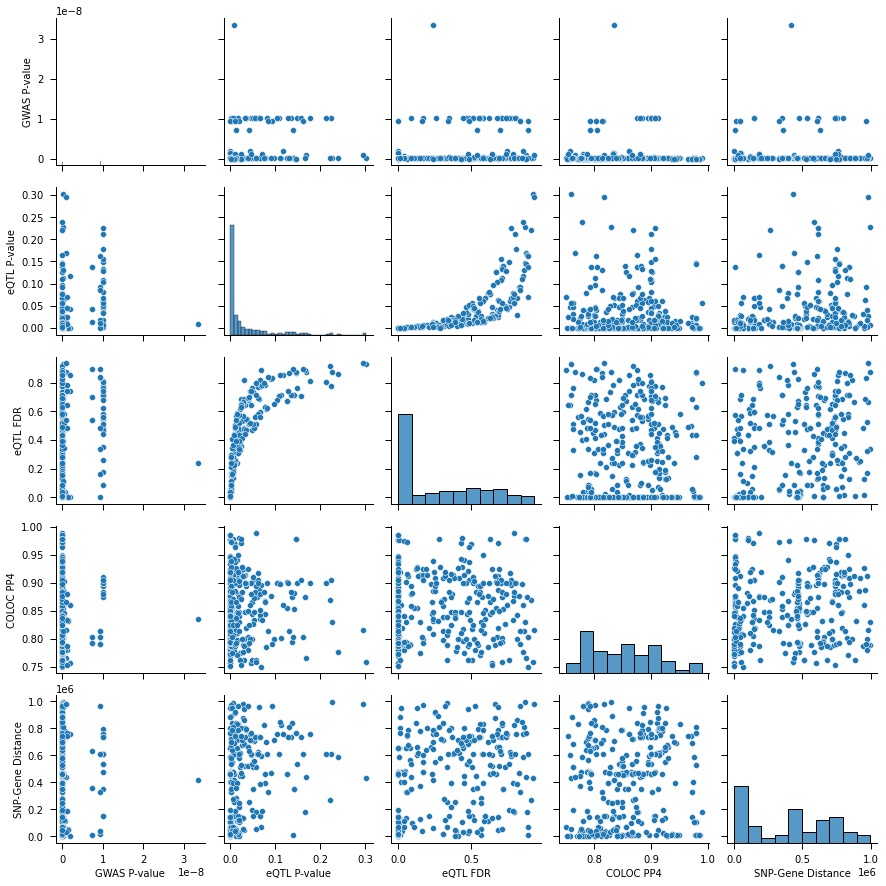

In [47]:
sns.pairplot(corr_data)

I thought I would see some kind of non-random relationship between GWAS/PP4 and eQTL/PP4. There is some filtering for significant GWAS and PP4 but I thought this relationship would still folder even after this. Not sure what to make of it as of right now. 

I talked with Sourya and I'm going to make a joint plot which is actually a heatmap with -log(GWAS) v. -log(eQTL) v. PP4.

/tmp/ipykernel_106662/2887589754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
/tmp/ipykernel_106662/2887589754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


(0.0, 50.0)

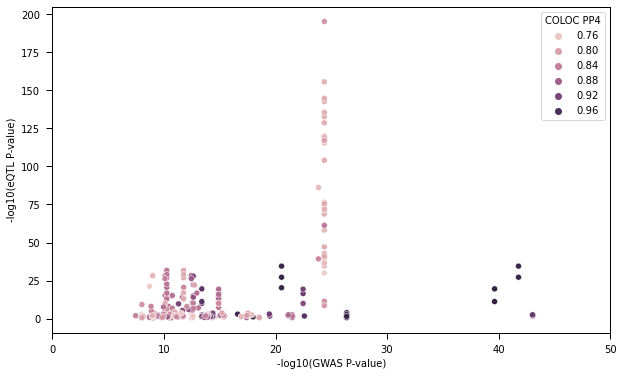

In [48]:
corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='-log10(GWAS P-value)',
                y='-log10(eQTL P-value)',
                hue='COLOC PP4',
                data=corr_data)
ax.set_xlim(0, 50)

/tmp/ipykernel_106662/65054163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
/tmp/ipykernel_106662/65054163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


(0.0, 10.0)

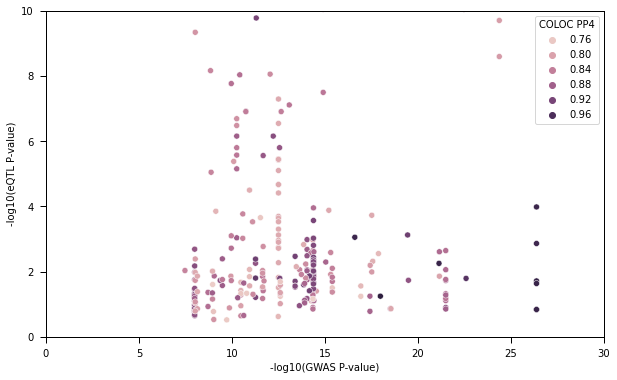

In [49]:
corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='-log10(GWAS P-value)',
                y='-log10(eQTL P-value)',
                hue='COLOC PP4',
                data=corr_data)
ax.set_xlim(0, 30)
ax.set_ylim(0, 10)

In [50]:
corr_data['GWAS P-value'].describe()

count     3.580000e+02
mean      1.132862e-09
std       3.398286e-09
min      1.110000e-233
25%       3.813819e-18
50%       4.026000e-14
75%       3.321140e-11
max       3.360000e-08
Name: GWAS P-value, dtype: float64

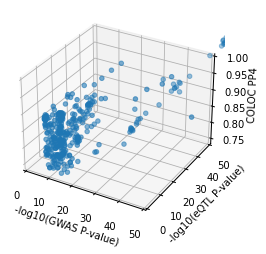

In [51]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

xlabel = '-log10(GWAS P-value)'
ylabel = '-log10(eQTL P-value)'
zlabel = 'COLOC PP4'


x = corr_data[xlabel]
y = corr_data[ylabel]
z = corr_data[zlabel]

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

ax.scatter(x, y, z)

ax.set_xlim(0, 50)
ax.set_ylim(0, 50)

plt.show()

## Make a circos plot

## Making the final table for poster: GWAS/eQTL/GE with genelist 

In [162]:
final = t1d_data.sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
final = final.groupby(['gwas_source', 'eqtl_source', 'ge_source'])
final = final.genename.unique()
final = final.to_frame().reset_index()
final.sort_values(['eqtl_source', 'ge_source'], inplace=True)
final = final.pivot(index='gwas_source', columns=['eqtl_source', 'ge_source'])
def genelist_to_str(x):
    
    if type(x) == float:
        return('None')
    else:
        l = sorted(x)
        l = ', '.join(l)
        l += '\nTotal Genes: ({})'.format(len(x))
        return(l)

final = final.applymap(genelist_to_str)
fn = os.path.join(outdir, 'poster-table.gwas.eqtl.ge.with_genelist.xlsx')
final.to_excel(fn)

## Making the final table for poster: GWAS/eQTL with genelist 

In [163]:
gencode_gene_types = ['protein_coding', 'IG_V_gene', 'IG_C_gene',
                         'IG_J_gene', 'TR_C_gene', 'TR_J_gene',
                         'TR_V_gene', 'TR_D_gene', 'IG_D_gene']

In [164]:
final_short = t1d_data.sort_values(['gwas_source', 'eqtl_source'])
final_short = final_short.loc[final_short['detailed-type'].isin(gencode_gene_types)]
final_short = final_short.groupby(['gwas_source', 'eqtl_source'])
final_short = final_short.genename.unique()
final_short = final_short.to_frame().reset_index()

final_short.sort_values(['eqtl_source'], inplace=True)
final_short = final_short.pivot(index='gwas_source', columns=['eqtl_source'])
final_short = final_short.applymap(genelist_to_str)

In [165]:
final_short

genename  \
eqtl_source                                               BLUEPRINT   
gwas_source                                                           
T1D_25751624                       ACTA2, NPIPB15\nTotal Genes: (2)   
T1D_32005708                                RPS26\nTotal Genes: (1)   
T1D_34012112_Gaulton       GLIS3, NPIPB15, TRIM61\nTotal Genes: (3)   
T1D_34594039_GCST90018925                                      None   

                                                                 \
eqtl_source                                             GENCORD   
gwas_source                                                       
T1D_25751624               CBS, DOK6, TMPRSS3\nTotal Genes: (3)   
T1D_32005708                     PRKCQ, RPS26\nTotal Genes: (2)   
T1D_34012112_Gaulton                                       None   
T1D_34594039_GCST90018925                                  None   

                                                                            \
eqtl_source                                                           GTEx   
gwas_source                                                                  
T1D_25751624               C11orf21, DOK6, DPP4, TMPRSS3\nTotal Genes: (4)   
T1D_32005708                                ASB13, RPS26\nTotal Genes: (2)   
T1D_34012112_Gaulton                          DPP4, ROR1\nTotal Genes: (2)   
T1D_34594039_GCST90018925                          BACH2\nTotal Genes: (1)   

                                                                              \
eqtl_source                                                        ImmuNexUT   
gwas_source                                                                    
T1D_25751624               ABCG1, ACTA2, ANKRD6, BBS7, C2CD2, DOK6, GABRR...   
T1D_32005708               ALDH2, ARMH2, BTN2A2, BTN3A2, GMNN, GPLD1, HIS...   
T1D_34012112_Gaulton       ABCG1, ACTA2, BCL11A, BEGAIN, C1QTNF6, C2CD2, ...   
T1D_34594039_GCST90018925                           BTN3A1\nTotal Genes: (1)   

                                                      \
eqtl_source                               Lepik_2017   
gwas_source                                            
T1D_25751624               TMPRSS3\nTotal Genes: (1)   
T1D_32005708                                    None   
T1D_34012112_Gaulton                            None   
T1D_34594039_GCST90018925                       None   

                                                                              \
eqtl_source                                                       Quach_2016   
gwas_source                                                                    
T1D_25751624               ANKRD22, CD226, CENPW, DOK6, LIPM\nTotal Genes...   
T1D_32005708                                                            None   
T1D_34012112_Gaulton                DOK6, GLIS3, TNFRSF11B\nTotal Genes: (3)   
T1D_34594039_GCST90018925                                               None   

                                                                              \
eqtl_source                                                   Schmiedel_2018   
gwas_source                                                                    
T1D_25751624               ANKRD22, BBS12, CENPW, CTLA4, DOK6, FGF2, GABR...   
T1D_32005708               AKR1C4, PRKCQ, RPS26, SLC22A18AS\nTotal Genes:...   
T1D_34012112_Gaulton       CACHD1, DOK6, DSCC1, HUS1B, NPIPB15, RGS1\nTot...   
T1D_34594039_GCST90018925               GABRR2, SLC22A18AS\nTotal Genes: (2)   

                                                            
eqtl_source                               van_de_Bunt_2015  
gwas_source                                                 
T1D_25751624                        TFF2\nTotal Genes: (1)  
T1D_32005708               AKR1C4, RPS26\nTotal Genes: (2)  
T1D_34012112_Gaulton                                  None  
T1D_34594039_GCST90018925                             None

In [166]:
def cell_list_to_str(x):
    
    if type(x) == float:
        return('None')
    else:
        l = sorted(x)
        l = ', '.join(l)
        return(l)


In [167]:
cell_lists = t1d_data[['eqtl_source', 'ge_source']].groupby('eqtl_source').ge_source.unique()
cell_lists = cell_lists.apply(cell_list_to_str)
final_short.loc['cell_lines', :] = cell_lists.tolist()

In [168]:
final_short

genename  \
eqtl_source                                               BLUEPRINT   
gwas_source                                                           
T1D_25751624                       ACTA2, NPIPB15\nTotal Genes: (2)   
T1D_32005708                                RPS26\nTotal Genes: (1)   
T1D_34012112_Gaulton       GLIS3, NPIPB15, TRIM61\nTotal Genes: (3)   
T1D_34594039_GCST90018925                                      None   
cell_lines                             T-cell, monocyte, neutrophil   

                                                                 \
eqtl_source                                             GENCORD   
gwas_source                                                       
T1D_25751624               CBS, DOK6, TMPRSS3\nTotal Genes: (3)   
T1D_32005708                     PRKCQ, RPS26\nTotal Genes: (2)   
T1D_34012112_Gaulton                                       None   
T1D_34594039_GCST90018925                                  None   
cell_lines                                          LCL, T-cell   

                                                                            \
eqtl_source                                                           GTEx   
gwas_source                                                                  
T1D_25751624               C11orf21, DOK6, DPP4, TMPRSS3\nTotal Genes: (4)   
T1D_32005708                                ASB13, RPS26\nTotal Genes: (2)   
T1D_34012112_Gaulton                          DPP4, ROR1\nTotal Genes: (2)   
T1D_34594039_GCST90018925                          BACH2\nTotal Genes: (1)   
cell_lines                                            LCL, blood, pancreas   

                                                                              \
eqtl_source                                                        ImmuNexUT   
gwas_source                                                                    
T1D_25751624               ABCG1, ACTA2, ANKRD6, BBS7, C2CD2, DOK6, GABRR...   
T1D_32005708               ALDH2, ARMH2, BTN2A2, BTN3A2, GMNN, GPLD1, HIS...   
T1D_34012112_Gaulton       ABCG1, ACTA2, BCL11A, BEGAIN, C1QTNF6, C2CD2, ...   
T1D_34594039_GCST90018925                           BTN3A1\nTotal Genes: (1)   
cell_lines                 CD16p_Mono, CL_Mono, CM_CD8, DN_B, EM_CD8, Fr_...   

                                                      \
eqtl_source                               Lepik_2017   
gwas_source                                            
T1D_25751624               TMPRSS3\nTotal Genes: (1)   
T1D_32005708                                    None   
T1D_34012112_Gaulton                            None   
T1D_34594039_GCST90018925                       None   
cell_lines                                     blood   

                                                                              \
eqtl_source                                                       Quach_2016   
gwas_source                                                                    
T1D_25751624               ANKRD22, CD226, CENPW, DOK6, LIPM\nTotal Genes...   
T1D_32005708                                                            None   
T1D_34012112_Gaulton                DOK6, GLIS3, TNFRSF11B\nTotal Genes: (3)   
T1D_34594039_GCST90018925                                               None   
cell_lines                 monocyte_IAV, monocyte_LPS, monocyte_Pam3CSK4,...   

                                                                              \
eqtl_source                                                   Schmiedel_2018   
gwas_source                                                                    
T1D_25751624               ANKRD22, BBS12, CENPW, CTLA4, DOK6, FGF2, GABR...   
T1D_32005708               AKR1C4, PRKCQ, RPS26, SLC22A18AS\nTotal Genes:...   
T1D_34012112_Gaulton       CACHD1, DOK6, DSCC1, HUS1B, NPIPB15, RGS1\nTot...   
T1D_34594039_GCST90018925               GABRR2, SLC22A18AS\nTotal Genes: (2)   
cell_lines                 B-cell_nai

In [169]:
fn = os.path.join(outdir, 'poster-table.gwas.eqtl.short.with_genelist.xlsx')
final_short.to_excel(fn)

## Differentiating GWAS only from GWAS + eQTL Based Results

In [170]:
num_both_driven = t1d_data.loc[t1d_data['eqtl_fdr'] < 0.05].shape[0]
num_gwas_driven = t1d_data.loc[t1d_data['eqtl_fdr'] > 0.05].shape[0]
driven_df = pd.DataFrame([['GWAS & eQTL', num_both_driven], ['GWAS Only', num_gwas_driven]])
driven_df.columns = ['Sig. Values', 'Count']

In [105]:
driven_df

,Sig. Values,Count
0,GWAS & eQTL,146
1,GWAS Only,205


/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sig. Values', ylabel='Count'>

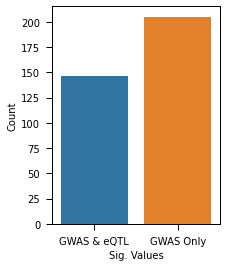

In [106]:
fig, ax = plt.subplots(figsize=(3,4))
sns.barplot('Sig. Values', 'Count', data=driven_df, ax=ax)

## Showing a Colocalization Plots for Important Gene

In [175]:
t1d_data.loc[t1d_data.genename == 'IL2RA']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge,sg_pair
115,chr10,6068912,rs7090530,10:6068912:C:A,IL2RA,0.942220,6587,7.242360e-11,1.969261e-08,0.214665,0.019149,0.185500,0.024500,4.026000e-14,T1D_32005708,ImmuNexUT,DN_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs7090530:ENSG00000134460
148,chr10,6056861,rs706779,10:6056861:T:C,IL2RA,0.876489,5464,9.850680e-15,3.835600e-12,-0.422397,0.004138,-0.166800,0.023800,2.250000e-12,T1D_32005708,ImmuNexUT,Naive_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs706779:ENSG00000134460
159,chr10,6068912,rs7090530,10:6068912:C:A,IL2RA,0.948410,6587,5.046700e-12,1.325424e-09,0.327085,0.008006,0.185500,0.024500,4.026000e-14,T1D_32005708,ImmuNexUT,SM_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs7090530:ENSG00000134460
174,chr10,6068912,rs7090530,10:6068912:C:A,IL2RA,0.945307,6587,2.433710e-20,1.710702e-17,0.317880,0.008501,0.185500,0.024500,4.026000e-14,T1D_32005708,ImmuNexUT,USM_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs7090530:ENSG00000134460
280,chr10,6068912,rs7090530,10:6068912:C:A,IL2RA,0.985454,6587,5.046700e-12,1.325424e-09,0.327085,0.008006,0.192842,0.014501,2.350000e-40,T1D_34012112_Gaulton,ImmuNexUT,SM_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs7090530:ENSG00000134460
296,chr10,6068912,rs7090530,10:6068912:C:A,IL2RA,0.984435,6587,2.433710e-20,1.710702e-17,0.317880,0.008501,0.192842,0.014501,2.350000e-40,T1D_34012112_Gaulton,ImmuNexUT,USM_B,ENSG00000134460,chr10,6052652.0,6104333.0,-,gene,protein_coding,both,rs7090530:ENSG00000134460


In [180]:
coloc_values = 'results/main/2021_Nikhil_eQTL/Results/ImmuNexUT/T1D_34012112_Gaulton/ImmuNexUT/SM_B/chr10_5617749_6617749/merged_SNPs_GWAS_input_colocalization.txt'

In [199]:
tdf = pd.read_table(coloc_values)
tdf = tdf.loc[tdf.geneName.str.match('ENSG00000134460')]

In [218]:
tdf['hue'] = 'Non-Coloc'
tdf.loc[tdf.pos == 6068912, 'hue'] = 'Coloc (PP4>0.75)'

In [219]:
tdf['-log10(eqtl_pval)'] = -1 * np.log10(tdf['pvalue'])
tdf['-log10(gwas_pval)'] = -1 * np.log10(tdf['pval_nominal'])

/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/tmp/ipykernel_26112/2129788407.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['A', '6Mb', '6.1Mb', '6.2Mb', '6.3Mb', '6.4Mb'])


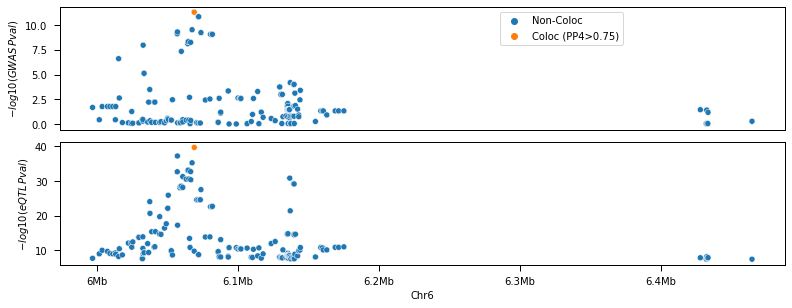

In [254]:
fig, axes = plt.subplots(nrows=2, figsize=(13,4.75), gridspec_kw={'hspace': 0.1})
sns.scatterplot('pos', '-log(eqtl_pval)', hue='hue', data=tdf, ax=axes[0])

# plot the GWAS scatterplot
sns.scatterplot('pos', '-log(gwas_pval)', hue='hue', data=tdf, ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('$-log10(GWAS\,Pval)$')
axes[0].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off

# move the legend
axes[0].legend(bbox_to_anchor=(0.6,1), loc="upper left")

# plot the eQTL scatterplot
axes[1].set_xlabel('Chr6')
axes[1].set_ylabel('$-log10(eQTL\,Pval)$')
axes[1].set_xticklabels(['A', '6Mb', '6.1Mb', '6.2Mb', '6.3Mb', '6.4Mb'])

axes[1].legend_.set_visible(False)

coloc_png = os.path.join(outdir, 'coloc-example.IL2RA.png')
fig.savefig(coloc_png, bbox_inches='tight', dpi=600)

/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/BioHome/jreyna/jreyna/software/mambaforge/envs/hichip-db/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


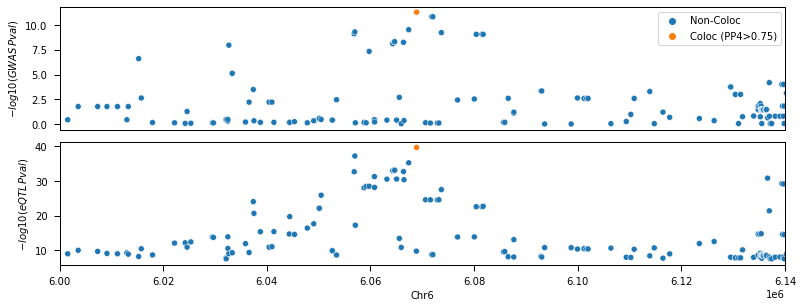

In [267]:
fig, axes = plt.subplots(nrows=2, figsize=(13,4.75), gridspec_kw={'hspace': 0.1})
sns.scatterplot('pos', '-log(eqtl_pval)', hue='hue', data=tdf, ax=axes[0])

# plot the GWAS scatterplot
sns.scatterplot('pos', '-log(gwas_pval)', hue='hue', data=tdf, ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('$-log10(GWAS\,Pval)$')
axes[0].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off

# move the legend
axes[0].legend(bbox_to_anchor=(0.8175,1), loc="upper left")

axes[0].set_xlim(6000000, 6140000)

# plot the eQTL scatterplot
axes[1].set_xlabel('Chr6')
axes[1].set_ylabel('$-log10(eQTL\,Pval)$')
#axes[1].set_xticklabels(['A', '6Mb', '6.1Mb', '6.2Mb', '6.3Mb', '6.4Mb'])

axes[1].legend_.set_visible(False)
axes[1].set_xlim(6000000, 6140000)
#axes[1].set_xticks([6000000, 6100000, 6180000])

coloc_png = os.path.join(outdir, 'coloc-example.IL2RA.png')
fig.savefig(coloc_png, bbox_inches='tight', dpi=600)